# Bonus: Proteus and Fowleri *Detection*

This notebook will guide students to distinguish between two types of amoebae: Amoeba proteus and Naegleria fowleri.

## Table of content


* Set up environment
* Load images dataset
* Data preparation and configurations
* Train custom amoeba model
* Evaluate amoeba model
* Inference

# Set up environment

We will install Mask R-CNN repo from Github (https://github.com/matterport/Mask_RCNN) and necessary packages. We need to make sure the packages we are using is the correct version.

In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.1.6
!pip install h5py==2.10.0
!pip install scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 58.1 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 503 kB 69.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=8e052e652bd54cabe0f378d1fe59ffbdb5c6a5af8ccdc4141468d7e45dba9198
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [ ]:
%%shell
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 35.87 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdis

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


# Load images dataset

We will clone the project from our github (https://github.com/BaosenZ/amoeba-detection.git). The dataset is included inside the github project.

In [ ]:
# download dataset from github

%%shell
# clone pro and fow dataset 
git clone https://github.com/BaosenZ/amoeba-detection.git


Cloning into 'amoeba-detection'...
remote: Enumerating objects: 2453, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 2453 (delta 178), reused 376 (delta 177), pack-reused 2075
Receiving objects: 100% (2453/2453), 354.59 MiB | 34.81 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Checking out files: 100% (3425/3425), done.


In [ ]:
# copy the dataset from github folder to 'content' 
!cp -r '/content/amoeba-detection/dataset-section2/amoebaProFowDataset/trainingDataset' '/content'
!cp -r '/content/amoeba-detection/dataset-section2/amoebaProFowDataset/testDataset' '/content'

In [ ]:
# upload zip of the dataset 

# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# !unzip trainingDataset.zip
# !unzip testDataset.zip

# Data preparation and configurations

Note that the function of `load_dataset()`, `load_mask()`,`extract_box()` need to change because one more class is added. 

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class AmoebaDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "Proteus Amoeba")
        self.add_class("dataset",2,"N.Fowleri Amoeba")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):
            image_id = filename[:-4]
            if is_train and int(image_id) >= 54:
                continue
            if not is_train and int(image_id) < 54:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # # load the masks for an image
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)

        tree = ElementTree.parse(path)
        root = tree.getroot()

        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = list()

        i = 0
        for obj in root.findall('.//object'):
        #for i in range(len(boxes)):
            if obj.find('name').text == 'Proteus Amoeba':
                box = boxes[i]
                row_s, row_e = box[1], box[3]
                col_s, col_e = box[0], box[2]
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Proteus Amoeba'))
            if obj.find('name').text == 'N.Fowleri Amoeba':
                box = boxes[i]
                row_s, row_e = box[1], box[3]
                col_s, col_e = box[0], box[2]
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('N.Fowleri Amoeba'))
            i = i + 1
        return masks, asarray(class_ids, dtype='int32')

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


# prepare train set
train_set = AmoebaDataset()
train_set.load_dataset('trainingDataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare val set
val_set = AmoebaDataset()
val_set.load_dataset('trainingDataset', is_train=False)
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))


Train: 53
Val: 9


Config files allow you to separate the code from the parameters of the machine learning pipeline to help produce repeatable outcomes.

In [ ]:
# prepare config
class AmoebaConfig(Config):
    NAME = "amoeba_cfg"
    NUM_CLASSES = 1 + 2
    STEPS_PER_EPOCH = 131
    DETECTION_NMS_THRESHOLD = 0.5

config = AmoebaConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Train amoeba dataset

In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. More information about Tensorboard is available here (https://www.tensorflow.org/tensorboard/get_started).

In [ ]:
# run tensorboard
import keras
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print(run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

./my_logs/run_2022_06_20-23_04_35


The Mask R-CNN structure is described in the paper(He, K., Gkioxari, G., Dollár, P. and Girshick, R., 2017. Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961-2969).) and also in my ppt.

In [ ]:
# train the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, val_set, learning_rate=0.002, epochs=20, layers='heads', custom_callbacks=[tensorboard_cb])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







Starting at epoch 0. LR=0.002

Checkpoint Path: ./amoeba_cfg20220620T2304/mask_rcnn_amoeba_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/20
130/131 [============================>.] - ETA: 1s - loss: 0.8665 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1559 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.2910 - mrcnn_mask_loss: 0.3061

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


131/131 [==============================] - 225s 2s/step - loss: 0.8629 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.1550 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.2897 - mrcnn_mask_loss: 0.3052 - val_loss: 0.7217 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.1727 - val_mrcnn_class_loss: 0.0461 - val_mrcnn_bbox_loss: 0.1924 - val_mrcnn_mask_loss: 0.3024

Epoch 2/20
131/131 [==============================] - 177s 1s/step - loss: 0.4204 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.2034 - val_loss: 0.7025 - val_rpn_class_loss: 0.0057 - val_rpn_bbox_loss: 0.1849 - val_mrcnn_class_loss: 0.0338 - val_mrcnn_bbox_loss: 0.1909 - val_mrcnn_mask_loss: 0.2872
Epoch 3/20
131/131 [==============================] - 177s 1s/step - loss: 0.3153 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1655 - val_loss: 0.6843 - val_rpn_class_loss: 0.006

# Evaluate amoeba dataset
 


Evaluate the mask rcnn model on the training, validation and test amoeba dataset

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

class PredictionConfig(Config):
	NAME = "amoeba_cfg"
	NUM_CLASSES = 1 + 2
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return APs, mAP



In [ ]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# !!!load model weights
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# find last trained weights: 
model_path = model.find_last()
model.load_weights(model_path, by_name=True)

# set a specific path
# model.load_weights('amoeba_cfg20211005T1749/mask_rcnn_amoeba_cfg_0020.h5', by_name=True) #the directory can be changed



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 20


In [ ]:
# load the test dataset
test_set = AmoebaDataset()
test_set.load_dataset('testDataset', is_train = False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# evaluate model on test dataset
test_APs, test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Test: 10
Test mAP: 0.983


In [ ]:
# visualize training in Tensorboard

# The tensorboard file name can be found in 'my_logs'. Then change the tensorboard file name.

# %load_ext tensorboard
# %tensorboard --logdir ./my_logs/run_2022_06_20-22_07_58

# Inference

## Test dataset inference



We will detect the images in testDataset folder by calling model.detect().Note that the function of `save_predicted()` need to change because one more class is added.

In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def save_predicted(image, model, cfg, filename):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  #print(yhat)
  pyplot.imshow(image)
  ax = pyplot.gca()
  pyplot.axis("off")
  for box,ids,confidence in zip(yhat['rois'],yhat['class_ids'],yhat['scores']):
    if ids == 1:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      confidence = format(confidence, '.3f')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)
    if ids == 2:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='green')
      confidence = format(confidence, '.3f')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)

  pyplot.savefig(filename,bbox_inches='tight',pad_inches=0.0)
  pyplot.show()


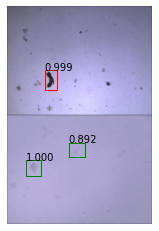

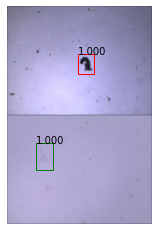

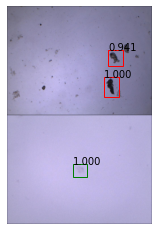

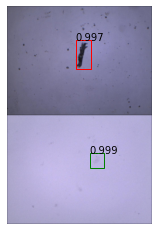

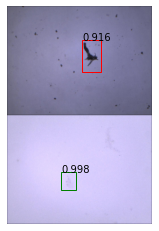

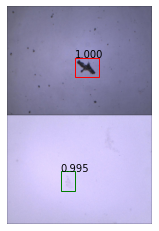

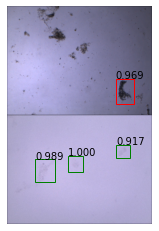

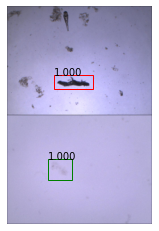

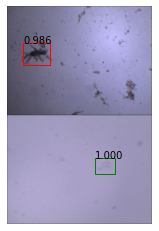

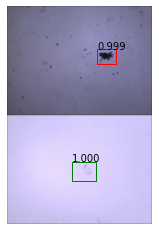

In [ ]:
from PIL import Image
if not os.path.exists("testDataset-pred"):
  os.mkdir("testDataset-pred")

images_dir = "amoeba-detection/dataset-level2/amoebaProFowDataset/testDataset/images"
save_root = "testDataset-pred/"

for img in listdir(images_dir):
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  save_file = save_root + img
  save_predicted(image, model, cfg, save_file)

In [ ]:
# save the inference folder to local

# !zip -r testDataset-pred.zip testDataset-pred
# from google.colab import files
# files.download("testDataset-pred.zip")